# Idee
-- modello per indovinare la regione dalle descrizioni? difficile? 

-- in base agli aggettivi della descrizione e alla regione prevedere il vino? o solo la tipologia? il prezzo? boh

-- classificare i vini in base alle descrizioni in cluster? a cosa può servire?

-- quanto DOVREBBE costare una bottiglia rispetto alle recensioni ricevute?  "percieved value"

# *Possibile proposta*

1) prevedere se a un determinato sommelier piacerà un determinato vino in base alle descrizioni dei vari vini? VIsto che nella taster "experience" analysis sembra palese che ci siano delle preferenze, magari a un'azienda vinicola che deve far assaggiare suoi prodotti a lui potrebbe interessare sapere le caratteristiche comuni di quelle che ha votato bene...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
data = pd.read_csv("winemag-data-130k-v2.csv")
data.drop(columns=["Unnamed: 0"],inplace=True)
len(data)

129971

In [ ]:
data

In [ ]:
len(data[data.duplicated('description',keep=False)].sort_values('description'))

In [ ]:
len(data[data.duplicated(['description',"price","points","country","province","title"],keep=False)].sort_values('description'))

In [2]:
data = data.drop_duplicates(["description","price","points","taster_name","title"])
len(data)

119988

In [ ]:
data.info()

.. tanti null sulla parte della designation, sulel due regioni e sui nomi dei reviewers

In [ ]:
len(data["title"].unique())

In [ ]:
data["title"].unique()

# Missing values and correlations

In [3]:
"""
missingOnlyName = 0
missingOnlyTwitter = 0
missingBoth = 0
lis = []
for idx,row in data.iterrows():
    #print(row["taster_name"])
    if(pd.isnull(row["taster_name"]) and (not pd.isnull(row["taster_twitter_handle"]))):
        missingOnlyName = missingOnlyName + 1
    if(pd.isnull(row["taster_twitter_handle"]) and (not pd.isnull(row["taster_name"]))):
        missingOnlyTwitter = missingOnlyTwitter + 1
    if(pd.isnull(row["taster_name"]) and pd.isnull(row["taster_twitter_handle"])):
        missingBoth = missingBoth + 1
    couple = [row["taster_name"],row["taster_twitter_handle"]]
    if not couple in lis:
        lis.append(couple)
print(missingOnlyName,missingOnlyTwitter,missingBoth)
print(lis,len(lis))
"""
data.drop(["taster_twitter_handle"],axis=1,inplace=True)

Dato che le twitter handle mancanti sono più dei nomi mancanti e non ci sono coppie (nome,twitter) del tipo ("nan","@sticaz") dalle quali si poteva risalire al nome originale così da avere meno valori sconosciuti, si può droppare tranquillamente il twitter handle senza perdere nulla

In [ ]:
data

In [ ]:
len(data["country"].unique())

In [4]:
avgPriceWinery = data.groupby("winery")#.price.mean()
#avgPriceWinery.get_group("1+1=3").price.mean()

In [5]:
data['price'] = data.apply(
    lambda row: avgPriceWinery.get_group(row["winery"]).price.mean() if pd.isnull(row['price']) else row['price'],
    axis=1
)
data["price"].fillna(data["price"].mean(),inplace=True)

#prende solo recensioni con autore conosciuto, ha senso come cosa?
#data.dropna(subset=["taster_name"],inplace=True)

data.fillna("unknown",inplace=True)

In [ ]:
data

In [ ]:
data[data["country"] == "Italy"]

sarebbe meglio riempire i nan del prezzo basandosi sulla media dei vini venduti dalla stessa cantina?

In [6]:
from sklearn.preprocessing import LabelEncoder

# encode labels with value between 0 and n_classes-1.
desig_encoder = LabelEncoder()
taster_encoder = LabelEncoder()
variety_encoder = LabelEncoder()
winery_encoder = LabelEncoder()
country_encoder = LabelEncoder()
province_encoder = LabelEncoder()

data['Desig_Code'] = desig_encoder.fit_transform(data['designation'])
data['Taster_Code'] = taster_encoder.fit_transform(data['taster_name'])
data['Variety_Code'] = variety_encoder.fit_transform(data['variety'])
data['Winery_Code'] = winery_encoder.fit_transform(data['winery'])
data['Country_Code'] = country_encoder.fit_transform(data['country'])
data['Province_Code'] = province_encoder.fit_transform(data['province'])

data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,Desig_Code,Taster_Code,Variety_Code,Winery_Code,Country_Code,Province_Code
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,17.0,Sicily & Sardinia,Etna,unknown,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,36805,9,690,11608,22,331
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,unknown,unknown,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2325,15,450,12956,31,108
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,37913,14,436,13018,40,268
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,unknown,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,27974,0,479,14390,40,218
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,36465,14,440,14621,40,268


In [ ]:
# calculate the correlation matrix
data1 = data[["Country_Code","Province_Code","price","points","Variety_Code","Taster_Code","Winery_Code","Desig_Code"]]
corr = data1.corr()
plt.subplots(figsize =(14, 12))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True)
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)

Price e points sono loosely correlated, perchè la correlation fra country e province è così bassa? forse perchè ci sono tante province all'interno di una nazione

# General analysis

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
points = data["points"].astype(int)
sns.distplot(points)

In [ ]:
fig, ax = plt.subplots(figsize = (7, 5))
ax =sns.boxplot(data["points"])

In [ ]:
x = data.dropna(subset=["price"])
fig, ax = plt.subplots(figsize = (7, 5))
ax = sns.distplot(x["price"])

La grandissima maggioranza dei vini costa meno di 100 dollari

In [ ]:
variety_df = data.groupby('variety').filter(lambda x: len(x) > 150)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

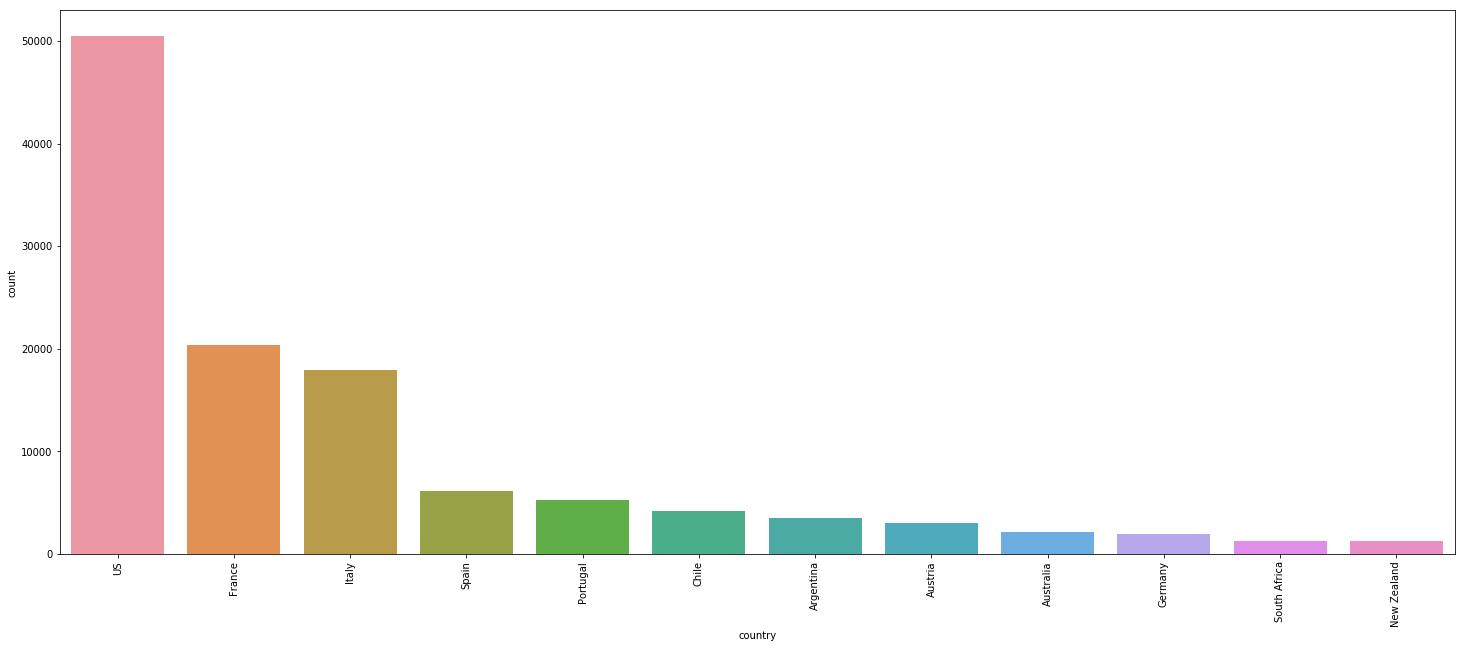

In [7]:
country = data.groupby("country").filter(lambda x: len(x)>500) #> tot perchè così prende i paesi un po' più interessanti visti i numeri
countryInfo = country['country'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = country['country'], order = countryInfo, ax = ax)
plt.xticks(rotation = 90)
plt.show()
#country.groups
#country.get_group("Argentina")

In [ ]:
country = data.groupby(["country"])
d1 = pd.DataFrame({"count":country["country"].count()}).reset_index()
d1 = d1[d1["count"] > 100].sum()
d1

In [ ]:
d2 = pd.DataFrame({"count":country["country"].count()}).reset_index()
d2 = d2[d2["count"] > 500].sum()
d2

In [ ]:
var = data.groupby("variety").filter(lambda x: len(x)>6000)
var = var.groupby("variety")
fig, ax = plt.subplots(figsize = (25, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in var:
    ax.plot(group["price"], group["points"], marker='o', linestyle='', ms=12, label=name)
plt.legend()
plt.show()

In [ ]:
sns.lmplot(x="points", y ="price",data = data)

-- In generale si può notare correlazione positiva fra prezzo e qualità: più è alto il prezzo, più tende ad essere buono il vino

In [ ]:
fig, ax = plt.subplots(figsize = (25, 10))
ax = sns.boxplot(x="country", y="points", data=country)

l'argentina, il chile, la romania e la spagna sembrano essere i paesi con le mediane più basse per quanto riguarda i punti. Mentre germania, austria e canada i più alti.

In [ ]:
fig, ax = plt.subplots(figsize = (25, 10))
ax = sns.scatterplot(x="country", y="price", data=country) #il boxplot viene male??

In [ ]:
fig, ax = plt.subplots(figsize = (25, 10))
ax = sns.boxplot(x="country", y="price", data=country) #il boxplot viene male??

In [ ]:
prov = data.groupby("province").filter(lambda x: len(x)>600) #> tot perchè così prende i paesi un po' più interessanti visti i numeri
provInfo = prov['province'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = prov['province'], order = provInfo, ax = ax)
plt.xticks(rotation = 90)
plt.show()

il dataset è palesemente "spostato" verso gli stati uniti e in particolare la california

# Winery analysis 

In [ ]:
wineries = data.groupby(["winery"])
d1 = pd.DataFrame({'mean_pts' : wineries["points"].mean(), "mean_price": wineries["price"].mean(),
                   "reviews_number": wineries["description"].nunique(), "variety_number":wineries["variety"].nunique(),
                  "varieties":wineries["variety"].unique().tolist()}
                 ).reset_index()
res = d1.sort_values(["reviews_number","mean_pts"],ascending=False)
res

In [ ]:
res.iloc[0]["varieties"][0]

In [ ]:
#prende quelle con un numero di entry maggiore di 10
res = res[res["reviews_number"] > 10]
fig, ax = plt.subplots(figsize = (25, 10))
ax = sns.scatterplot(x="mean_pts", y="variety_number", data=res)

Si può notare come la parte in mezzo "meh points" facciano un alto numero di vini, mentre quelli con i punteggi più alti si concentrano su meno di 5 varietà. Si può dire che chi si concentra solo su una cosa va meglio? 

In [ ]:
fig, ax = plt.subplots(figsize = (25, 10))
ax = sns.distplot(res["mean_pts"])

In [ ]:
fig, ax = plt.subplots(figsize = (25, 10))
ax = sns.scatterplot(x="mean_pts", y="mean_price", data=res)

Palese la presenza ancora di un trend, anche per quanto riguarda le cantine. Più una cantina ha una media di punteggi migliori, più tende a far pagare le bottiglie, notare come le cantine votate meglio hanno un prezzo più basso rispetto alle altre controparti dai punteggi alti.

# **Taster "experience" analysis** , me gusta, interessante
Curioso per quanto riguarda i tasters, rimaneggio un po' i dati per averli in un altro dataframe più comodo per vedere come si comportano dal punto di vista della varietà di vini assaggiati

In [ ]:
testers = data.groupby("taster_name").filter(lambda x: len(x)>0) #> tot perchè così prende i paesi un po' più interessanti visti i numeri
print(testers["taster_name"].unique())
testerInfo = testers['taster_name'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = testers['taster_name'], order = testerInfo, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
#togli i taster sconosciuti? 
reviewers = data["taster_name"].unique().tolist()
len(reviewers)
countries = data["country"].unique().tolist()

In [ ]:
countriesTasted = []
for r in reviewers:
    d1 = data[data["taster_name"] == r]
    temp = dict(d1["country"].value_counts())
    wines = d1["variety"].unique().tolist()
    wineries = d1["winery"].unique().tolist()
    countriesTasted.append([r,temp,wines,wineries])
#countriesTasted
stacked = pd.DataFrame(columns = ["taster","#countries","#varieties","#wineries"]+countries)
for i in range(0,len(countriesTasted)):
    stacked.loc[i,"taster"] = (countriesTasted[i][0])
    stacked.loc[i,"#countries"] = len(countriesTasted[i][1])
    stacked.loc[i,"#varieties"] = len(countriesTasted[i][2])
    stacked.loc[i,"#wineries"] = len(countriesTasted[i][3])
    for c in countriesTasted[i][1]:
        stacked.loc[i,c] = countriesTasted[i][1][c]
stacked = stacked.fillna(0)
stacked
#stacked.describe()

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.distplot(stacked["#countries"])
plt.show()

su 44 paesi presenti, tutti hanno assaggiato vini provenienti da meno della metà.

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.distplot(stacked["#varieties"])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.distplot(stacked["#wineries"])
plt.show()

tanti taster hanno assaggiato vini provenienti da meno di 5 paesi,in media almeno 100 varietà diverse di vino, da generalmente 500 cantine diverse

In [ ]:
t1 = data.groupby(["taster_name","variety"])
t2 = pd.DataFrame({'mean_pts' : t1["points"].mean(), "times_reviewed": t1["description"].count(),
                   "norm_points": 1 - (t1["points"].mean()/ t1["description"].count())} # norm1: 1/(media voto/count), another norm 1-(media voto/conto totale), da valori vicini a 1 per quelli più alti
                 ).reset_index()   #forse è meglio la 1 - ...
#res = d1.sort_values(["reviews_number","mean_pts"],ascending=False)
t2 = t2[t2["times_reviewed"] > 30]
final = t2.sort_values(["times_reviewed","mean_pts"])#,ascending=False)
final

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.distplot(final["times_reviewed"])
plt.show()

In [ ]:
#non contiamo gli unkwnown
f1 = final[final["taster_name"] == "Roger Voss"]
f1

In [ ]:
#based on row data, not normalized based on how many times he reviewed it
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.scatterplot(x ="mean_pts",y="variety",data=f1)
plt.show()
#normalized attempt
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.scatterplot(x ="norm_points",y="variety",data=f1)
plt.show()

In [ ]:
#not normalized another author
f2 = final[final["taster_name"] == "Kerin O’Keefe"]
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.scatterplot(x ="mean_pts",y="variety",data=f2)
plt.show()
fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.scatterplot(x ="norm_points",y="variety",data=f2)
plt.show()

In [ ]:
#testers = data.groupby(["taster_name","country"])
#for name,group in testers:
#    print(name)
#    print(len(group))

Potrebbero esserci "bias" o comunque preferenze dei vini da parte di persone che hanno assaggiato vini provenienti da meno paesi? cioè se uno ha provato vini statunitensi e basta magari ha assegnato un voto più alto di quello che uno che ha assaggiato 203020 vini da paesi diversi perchè magari non ha idea di cosa voglia dire

magari da provare a comparare i punteggi sugli stessi vini fra personaggi diversi

controlla anche le cose della designation "designationThe vineyard within the winery where the grapes that made the wine are from"

In [ ]:
"""
desig = data.groupby(["designation"])
desig["designation"].count()
"""


In [ ]:
revs = data.groupby(["title"]).filter(lambda x: len(x) >= 2)
len(revs)

-- La grandissima maggioranza delle recensioni è "singola", solo una persona ha assaggiato e ha dato il voto? o dups?

In [ ]:
#revs.groupby(["title"]).groups
#pd.DataFrame({'count' : revs.groupby([ "title"] ).size(),"mean":5}).reset_index()


In [ ]:
singleTitleExample = revs[revs["winery"] == "Gloria Ferrer"]
singleTitleExample["title"].unique()

In [ ]:
#singleTitleExample["taster_name"].unique()

In [ ]:
#ex1 = revs[revs["title"] == "Roland Champion NV Brut Rosé  (Champagne)"]
#ex1

In [ ]:
#ex1 = revs[revs["title"] == "Ferrari-Carano 2014 Siena Red (Sonoma County)"]
#ex1

In [ ]:
#ex1 = revs[revs["title"] == "Liebart-Régnier NV Brut  (Champagne)"]
#ex1 

Stessi reviewer due descrizioni diverse, con voti diversi, sullo stesso titolo, ma con prezzi diversi? Wot? Sempre un problema che molti reviewer sono senza nome

# analisi veloce delle recensioni senza nome
non so se tenerle o meno

In [ ]:
unknown = data[data["taster_name"] == "unknown"]
len(unknown)

In [ ]:
data2 = unknown[["Country_Code","Province_Code","price","points","Variety_Code","Winery_Code","Desig_Code"]]
corr = data2.corr()
plt.subplots(figsize =(14, 12))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,annot=True)
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)

le correlazioni sono più alte

In [ ]:
country = unknown.groupby("country").filter(lambda x: len(x)>100) #> tot perchè così prende i paesi un po' più interessanti visti i numeri
countryInfo = country['country'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (10, 10))
sns.countplot(x = country['country'], order = countryInfo, ax = ax)
plt.xticks(rotation = 90)
plt.show()


recensioni fatte solo per quanto riguarda usa, italia, australia, francia e chile. 24 mila

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.boxplot(x="country", y="points", data=country)